# lab6

In [10]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [11]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 – Population Growth Rate

In [12]:
q1_sql = """
SELECT
    year,
    pop::numeric AS population,
    ROUND(
        ((pop::numeric - LAG(pop::numeric) OVER (ORDER BY year)) 
         / LAG(pop::numeric) OVER (ORDER BY year)) * 100,
        2
    ) AS yoy_growth_percent
FROM population
WHERE fips = '06'
ORDER BY year;


"""

In [13]:
import pandas as pd

q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head() #show the top 5 rows

/tmp/ipykernel_7366/2656640038.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,year,population,yoy_growth_percent
0,2005,35278768.0,NaN
1,2006,36457549.0,3.34
2,2007,36553215.0,0.26
3,2008,36756666.0,0.56
4,2009,36961664.0,0.56


In [14]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.2 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install "jupyter-ai-magics[all]" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [19]:
%load_ext jupyter_ai_magics

In [20]:
%%ai gpt4 -f code
use data in {q1_df}, create a line chart with the growth rate. 
        Chart must include the CA state name in the title

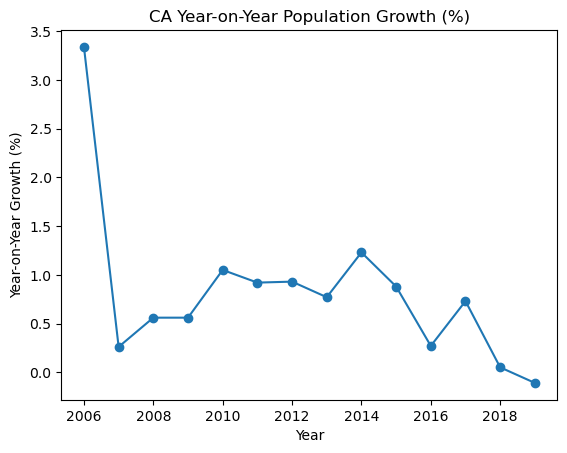

In [21]:
import matplotlib.pyplot as plt

# Data
years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
yoy_growth_percent = [None, 3.34, 0.26, 0.56, 0.56, 1.05, 0.92, 0.93, 0.77, 1.23, 0.88, 0.27, 0.73, 0.05, -0.11]

# Create figure and axis
fig, ax = plt.subplots()

# Plot data
ax.plot(years, yoy_growth_percent, marker='o')

# Set title and labels
ax.set_title('CA Year-on-Year Population Growth (%)')
ax.set_xlabel('Year')
ax.set_ylabel('Year-on-Year Growth (%)')

# Show plot
plt.show()

The pop growth rate dropped from 2006 to 2007, additionally it peaked from 2013 to 2014. Trends are unsteady and show increases and decreases thorughout the years, yet nothing dramatic.

## Q2 - Income and Population Relationship

In [22]:
q2_sql = """
SELECT 
    n.name AS state,
    i.year,
    p.pop AS population,
    i.income
FROM income i
JOIN population p
    ON i.fips = p.fips 
   AND i.year = p.year
JOIN name n
    ON i.fips = n.fips
WHERE n.name = 'California'
  AND n.fips = '06'
ORDER BY i.year ASC;

"""

In [23]:
import pandas as pd

q2_df = pd.read_sql(q2_sql, con=conn)
q2_df.head() #show the top 5 rows

/tmp/ipykernel_7366/3338859629.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(q2_sql, con=conn)


,state,year,population,income
0,California,2005,35278768,53629
1,California,2006,36457549,56645
2,California,2007,36553215,59948
3,California,2008,36756666,61021
4,California,2009,36961664,58931


In [24]:
%%ai gpt4 -f code
use data in {q2_df}, create a dual-axis chart.
    X-axis = year
    Left Y-axis = population (line)
    Right Y-axis = median household income (bar or line, different color)
    Chart must include the CA state name in the title

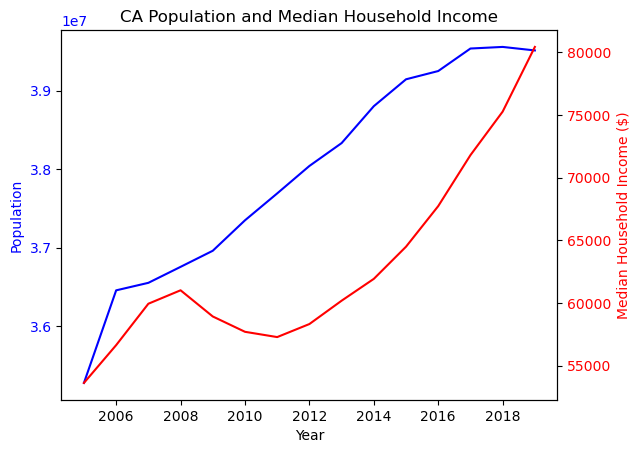

In [25]:
import matplotlib.pyplot as plt

# Data
years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
population = [35278768, 36457549, 36553215, 36756666, 36961664, 37349363, 37691912, 38041430, 38332521, 38802500, 39144818, 39250017, 39536653, 39557045, 39512223]
income = [53629, 56645, 59948, 61021, 58931, 57708, 57287, 58328, 60190, 61933, 64500, 67739, 71805, 75277, 80440]

# Create figure and axis
fig, ax1 = plt.subplots()

# Line plot for population
ax1.plot(years, population, color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Bar or Line plot for income on another axis
ax2 = ax1.twinx()  
ax2.plot(years, income, color='red')  # change this line to ax2.bar(years, income, color='red') if bar representation is desired
ax2.set_ylabel('Median Household Income ($)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title
plt.title('CA Population and Median Household Income')

# Show plot
plt.show()

This graph shows that between 2005 and 2019, California's population and median household income both increased steadily, though not at the same pace. Population (blue) grew gradually throughout the period, while median household income(red) fluctuated slightly around 2008–2012 before rising sharply after 2013, indicating strong economic recovery and growth.

## Q3 - Student Defined Question

decade growth percentage

In [33]:
q3_sql = """
WITH decade_pop AS (
    SELECT
        (year / 10) * 10 AS decade,
        FIRST_VALUE(pop) OVER (PARTITION BY (year / 10) * 10 ORDER BY year) AS start_pop,
        LAST_VALUE(pop) OVER (PARTITION BY (year / 10) * 10 ORDER BY year
                              ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS end_pop
    FROM population
    WHERE fips = '06'
)
SELECT DISTINCT
    decade,
    ROUND(((end_pop - start_pop) / start_pop::numeric) * 100, 2) AS decade_growth_percent
FROM decade_pop
ORDER BY decade;

"""

In [46]:
import pandas as pd

q3_df = pd.read_sql(q3_sql, con=conn)
q3_df.head() #show the top 5 rows

/tmp/ipykernel_7366/2998452085.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q3_df = pd.read_sql(q3_sql, con=conn)


,decade,decade_growth_percent
0,2000,4.77
1,2010,5.79


In [47]:
%%ai gpt4 -f code
use data in the dataframe of {q3_df}, create a bar chart.
    X-axis = decade
    Y-axis = decade growth rate
    Chart must include the CA state name in the title

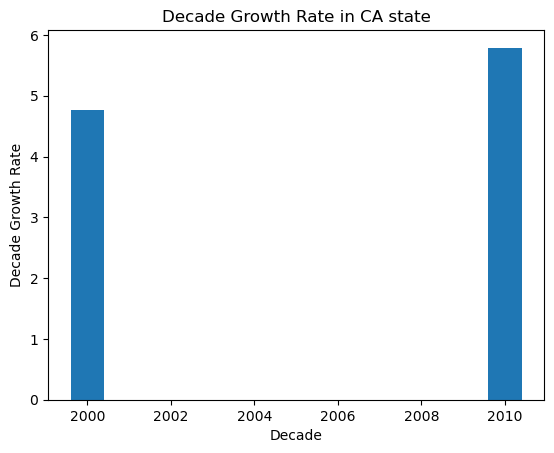

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the input data is stored in a dataframe named 'df'
df = pd.DataFrame({'decade': [2000, 2010], 'decade_growth_percent': [4.77, 5.79]})

plt.bar(df['decade'], df['decade_growth_percent'])
plt.title('Decade Growth Rate in CA state')
plt.xlabel('Decade')
plt.ylabel('Decade Growth Rate')
plt.show()

Over a decade, from 2000 to 2010, there was growth. This growth was not dramatic, but should be noted when looking at CA as a state. 